# *Internal Lab - Residency 9*

## Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf

In [0]:
#Reset Default graph - Needed only for Jupyter notebook
tf.reset_default_graph()
tf.set_random_seed(40)

### Import the necessary libraries

In [0]:
# IMPORT LIBRARIES AND PACKAGES
import pandas as pd
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Load the training data from train.csv file

In [0]:
traindata = pd.read_csv('/content/drive/My Drive/AIML/Labs/RESIDENCY 9/R9_Internal Lab/train_labels.csv')

### Print the shape of the train dataset

In [12]:
traindata.shape

(173, 8)

In [13]:
traindata.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399
7,raccoon-200.jpg,261,193,raccoon,107,10,249,166
8,raccoon-141.jpg,249,202,raccoon,1,1,154,176
9,raccoon-19.jpg,259,194,raccoon,87,8,182,89


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import os 
os.chdir('/content/drive/My Drive/AIML/Labs/RESIDENCY 9/R9_Internal Lab/')

In [16]:
pwd

'/content/drive/My Drive/AIML/Labs/RESIDENCY 9/R9_Internal Lab'

In [0]:
import csv
with open('train_labels.csv', 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))   
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    
    for col, row in enumerate(reader):
                
        for i, r in enumerate(row[1:3]): # Parse row with seven entities  
            row[i+1] = int(r)
          
        for i, r in enumerate(row[4:8]): # Parse row with seven entities
            #print(i,r)
            row[i+4] = int(r)
        #print(type(row[7]))
        path, image_height, image_width,classes, x0, y0, x1, y1 = row  
        path = "/content/drive/My Drive/AIML/Labs/RESIDENCY 9/R9_Internal Lab/images" + "/" + path.split('/')[-1]
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    #print(i)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [22]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

Instructions for updating:
Colocations handled automatically by placer.
17227776/17225924 [==============================] - 1s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou


### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [24]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


### Pick a test image from the given data

In [25]:
model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
173/173 [==============================] - 4s 21ms/step - loss: 3291.0327 - IoU: 0.0799
Epoch 2/30
173/173 [==============================] - 0s 532us/step - loss: 996.7134 - IoU: 0.3842
Epoch 3/30
173/173 [==============================] - 0s 570us/step - loss: 915.1663 - IoU: 0.4055
Epoch 4/30
173/173 [==============================] - 0s 555us/step - loss: 847.3656 - IoU: 0.4600
Epoch 5/30
173/173 [==============================] - 0s 542us/step - loss: 583.2179 - IoU: 0.5206
Epoch 6/30
173/173 [==============================] - 0s 547us/step - loss: 473.6890 - IoU: 0.5337
Epoch 7/30
173/173 [==============================] - 0s 517us/step - loss: 431.6505 - IoU: 0.5497
Epoch 8/30
173/173 [==============================] - 0s 541us/step - loss: 349.3354 - IoU: 0.5966
Epoch 9/30
173/173 [==============================] - 0s 489us/step - loss: 309.2556 - IoU: 0.6219
Epoch 10/30
173/173 [==============================] - 0s 545

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
import cv2
filename = '/content/drive/My Drive/AIML/Labs/RESIDENCY 9/R9_Internal Lab/images/raccoon-139.jpg'
unscaled = cv2.imread(filename)

### Predict the coordinates of the bounding box for the given test image

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0]

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) 
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

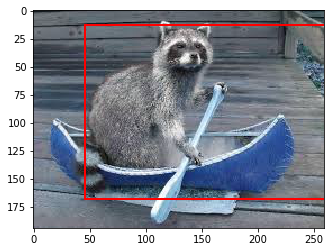

In [31]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Problem 2 : Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

### Load the  data file

In [33]:
df = pd.read_csv('/content/drive/My Drive/AIML/Labs/RESIDENCY 9/R9_Internal Lab/daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())

            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


### Plot the data

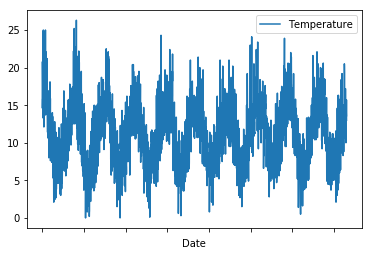

In [34]:
df.plot()

### Check for null values and treat them

In [35]:
df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values (if any)

In [0]:
# No null values

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a277f1a90>]],
      dtype=object)

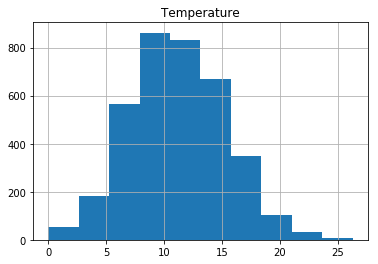

In [37]:
df.hist(bins=10)

### Check the maximum and minimum values

In [38]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
dataset = df.astype('float32')

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Check the maximum and minimum values of scaled data

In [41]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [42]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [44]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [45]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


### Define sequntial model, add LSTM layer and compile the model

In [0]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Train the model for 100 epochs with batch size = 1

Note using 15 epochs only as 100 epochs taking too much time


In [47]:
model.fit(X_train, y_train, epochs=15, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/15
 - 13s - loss: 0.0254
Epoch 2/15
 - 11s - loss: 0.0175
Epoch 3/15
 - 11s - loss: 0.0151
Epoch 4/15
 - 11s - loss: 0.0137
Epoch 5/15
 - 10s - loss: 0.0130
Epoch 6/15
 - 11s - loss: 0.0119
Epoch 7/15
 - 11s - loss: 0.0110
Epoch 8/15
 - 12s - loss: 0.0106
Epoch 9/15
 - 11s - loss: 0.0105
Epoch 10/15
 - 11s - loss: 0.0103
Epoch 11/15
 - 11s - loss: 0.0103
Epoch 12/15
 - 11s - loss: 0.0103
Epoch 13/15
 - 11s - loss: 0.0103
Epoch 14/15
 - 11s - loss: 0.0104
Epoch 15/15
 - 11s - loss: 0.0104


### Make Predictions and Evaluate your model

In [48]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.64 RMSE
Test Score: 2.49 RMSE


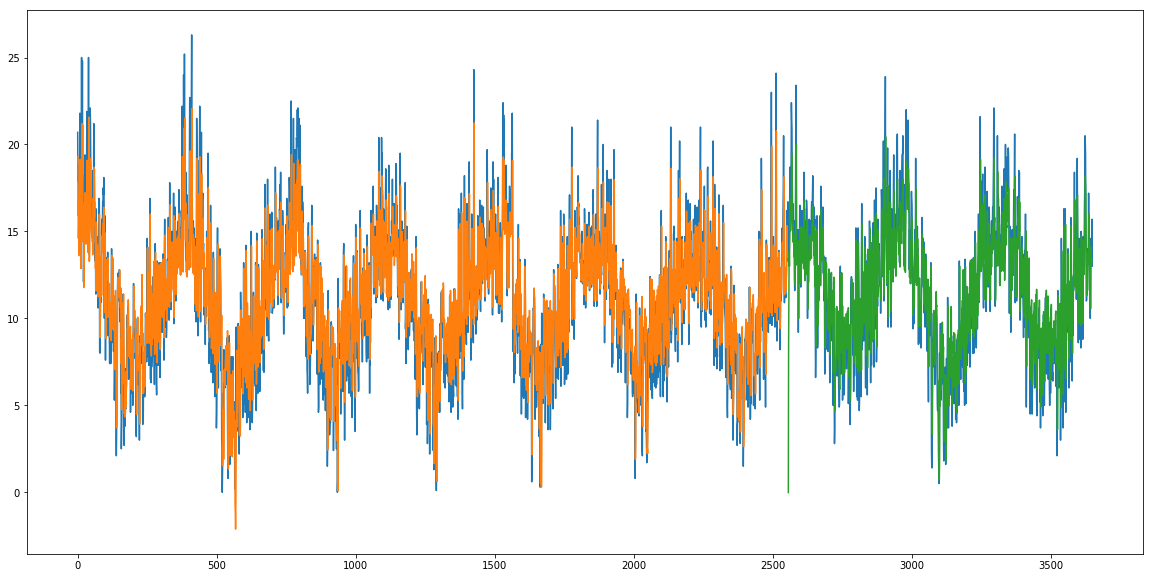

In [49]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()